# LDA

In [1]:
# import sys
# !{sys.executable} -m pip install stop-words

In [2]:
import pandas as pd
import numpy as np
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('seaborn-bright')
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import defaultdict # for word frequency

#### Read in CB data

In [3]:
data = pd.read_csv('data.csv')

In [4]:
# add central bank identifiers
def cb_id(s):
    if 'Australia' in s:
        return 'RBA'
    elif 'US' in s:
        return 'US'
    elif 'European' in s:
        return 'ECB'
    elif 'Japan' in s:
        return 'BoJ'
    elif 'Canada' in s:
        return 'BoC'
    elif 'New Zealand' in s:
        return 'RBNZ'
    elif 'England' in s:
        return 'BoE'
    elif 'Sweden' in s:
        return 'Riksbank'
    elif 'Norges' in s:
        return 'Norges'
        
data['Central_Bank'] = data.ID.map(cb_id)

#### Some preliminary data cleaning
* remove papers with missing abstracts
* keep only abstracts from year 2000 onwards
* reset index

In [5]:
# remove papers where the abstract is not available
data          = data[data.Abstract != 'No abstract available']

# remove papers before 1998
data = data[data.Year > '1999']
data = data[data.Year != "undated"]

data.index = range(len(data))

In [6]:
len(data)

6637

#### Preprocessing function

In [7]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# create English stop words list
en_stop = set(stopwords.words('english'))
# add context-specific stop words to list
en_stop = en_stop.union(["per","cent","one","two","three","four","five","six","seven","eight","nine","use",
                         "using","also","paper","results","evidence","suggests","implies","indicates","jel","find",
                         "finding",'hypothesis',"classification","area","effect",'discuss', 
                         "canada","canadian","australia","australian","japan","japanese","new zealand",
                         "swedish","sweden","norway","norwegian"])
    
def preprocess(s):
    
    # make lower case
    s = s.lower()
    
    # remove all numbers
    s = re.sub(r'[0-9]+', '', s)
       
    # create p_stemmer of class PorterStemmer
    p_stemmer  = PorterStemmer()
    
    # create lemmatizer of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tokenize string
    token_pattern=r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    s = token_pattern.findall(s)

    # remove stop words from tokens
    s = [i for i in s if not i in en_stop]
    
#     # stem words
#     s = [p_stemmer.stem(i) for i in s] 

    # lemmatize words
    s = [lemmatizer.lemmatize(i) for i in s] 
    
    return s

#### Example of the difference between lemmatizing and stemming 
* NB: This is for the example referred to in the text

In [8]:
p_stemmer  = PorterStemmer()
import nltk
lemmatizer = WordNetLemmatizer()

eg1_stem  = p_stemmer.stem("productivity")
eg1_lemma = lemmatizer.lemmatize("forecasting")

print(eg1_stem, eg1_lemma)

product forecasting


#### Apply preprocessing

In [9]:
abst = data.Abstract.map(preprocess)

In [10]:
len(abst)

6637

#### Build LDA model
* **NB**: topic model has already been run 
* Just load the 'preliminary_LDA_v2.sav' model
* Have also experimented with a 15-topic model with very similar results

In [11]:
from gensim import corpora, models
dictionary = corpora.Dictionary(abst)

In [12]:
corpus     = [dictionary.doc2bow(text) for text in abst]

In [13]:
# Already run & saved; just call the model below 
# ldamodel     = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=200)

In [14]:
import pickle

# save the model to disk
#filename     = 'preliminary_LDA_v2.sav'
#pickle.dump(ldamodel, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk

filename     = 'preliminary_LDA_v2.sav'
# filename     = 'preliminary_LDA_15.sav'
ldamodel     = pickle.load(open(filename, 'rb'))

In [15]:
##pp.pprint(ldamodel.show_topics(num_topics=-1, num_words=10, formatted=False))

#### Examine topic word lists for the 10-topics

In [16]:
topics_words = ldamodel.show_topics(num_topics=-1, num_words=6, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topics_words]

#Below code prints only words
topics_words_list = []
for topic, words in topics_words:
    topics_words_list.append(" ".join(words))

topics_words_list

['policy monetary inflation rate central bank',
 'country price exchange rate euro economy',
 'market liquidity payment transaction price reserve',
 'model forecast data time method approach',
 'household income housing tax wealth consumption',
 'model shock price output inflation real',
 'rate interest term market bond yield',
 'firm wage growth market level productivity',
 'risk asset default portfolio capital credit',
 'bank financial credit crisis loan firm']

#### Create dictionary of the resulting topic descriptions

In [17]:
# NB: this is from the 15-topic model (ignore)

# topics = {}
# topics = {
#     0: topics_words_list[0],
#     1: topics_words_list[1],
#     2: topics_words_list[2],
#     3: topics_words_list[3],
#     4: topics_words_list[4],
#     5: topics_words_list[5],
#     6: topics_words_list[6],
#     7: topics_words_list[7],
#     8: topics_words_list[8],
#     9: topics_words_list[9],
#     10: topics_words_list[10],
#     11: topics_words_list[11],
#     12: topics_words_list[12],
#     13: topics_words_list[13],
#     14: topics_words_list[14]
# }

In [18]:
topics = {}
topics = {
    0: topics_words_list[0],
    1: topics_words_list[1],
    2: topics_words_list[2],
    3: topics_words_list[3],
    4: topics_words_list[4],
    5: topics_words_list[5],
    6: topics_words_list[6],
    7: topics_words_list[7],
    8: topics_words_list[8],
    9: topics_words_list[9]
}

#### Apply to subset of articles to check

In [19]:
# Let's check the first 10 abstracts and see what the min probability should be,
# and if the assigned topics make sense

abst_topics_test = []
for abstract in np.arange(1250,1260):
    abst_topics_test.append(ldamodel.get_document_topics(corpus[abstract], 
                                           minimum_probability=0.10,   
                                           # minprob to be adjusted based on no of topics generated by the model
                                           minimum_phi_value=None, 
                                           per_word_topics=False))

In [20]:
# Looks very sensible if you cross-check against relevent article!!
abst_topics_test

[[(0, 0.9763076)],
 [(4, 0.9009165)],
 [(0, 0.53462106), (3, 0.3801502)],
 [(3, 0.43778104), (6, 0.37858826)],
 [(0, 0.12226912), (3, 0.6172532), (7, 0.13968563)],
 [(0, 0.2246402), (3, 0.12798487), (5, 0.5277132)],
 [(3, 0.43734273), (6, 0.28354424), (7, 0.2679524)],
 [(0, 0.2526688), (4, 0.63740504), (6, 0.10427581)],
 [(4, 0.4547547), (5, 0.12797858), (7, 0.2734173)],
 [(5, 0.74950415)]]

In [21]:
from operator import itemgetter

for i in abst_topics_test:
    i.sort(key=itemgetter(1),reverse=True)

In [22]:
for k,v in enumerate(abst_topics_test,start=1250):
    print(k,v)

1250 [(0, 0.9763076)]
1251 [(4, 0.9009165)]
1252 [(0, 0.53462106), (3, 0.3801502)]
1253 [(3, 0.43778104), (6, 0.37858826)]
1254 [(3, 0.6172532), (7, 0.13968563), (0, 0.12226912)]
1255 [(5, 0.5277132), (0, 0.2246402), (3, 0.12798487)]
1256 [(3, 0.43734273), (6, 0.28354424), (7, 0.2679524)]
1257 [(4, 0.63740504), (0, 0.2526688), (6, 0.10427581)]
1258 [(4, 0.4547547), (7, 0.2734173), (5, 0.12797858)]
1259 [(5, 0.74950415)]


#### Apply topics to articles and merge topics into dataframe

In [23]:
# Ok, now let's add the topics to a list to add to the articles
abst_topics = []
for abstract in corpus:
    abst_topics.append(ldamodel.get_document_topics(abstract, 
                                           minimum_probability=0.1,   
                                           # minprob to be adjusted based on no of topics generated by the model!
                                           minimum_phi_value=None, 
                                           per_word_topics=False))

In [24]:
# Let's see if the two line up
print(len(abst_topics),len(data))

6637 6637


In [25]:
data['topics'] = abst_topics

In [26]:
data.head(2)

,Author/s,Year,Title,ID,Abstract,Central_Bank,topics
0,"James Bishop & Iris Chan, 2019.\n """,2019,Is Declining Union Membership Contributing to ...,"rdp2019-02, Reserve Bank of Australia.",The union membership rate has declined steadil...,RBA,"[(7, 0.91146475)]"
1,"Trent Saunders & Peter Tulip, 2019.\n """,2019,A Model of the Australian Housing Market,"rdp2019-01, Reserve Bank of Australia.",We build an empirical model of the Australian ...,RBA,"[(1, 0.111991614), (4, 0.31667885), (5, 0.1641..."


#### Create columns with name of each topic

In [27]:
for t in np.arange(0,10):
# for t in np.arange(0,15):
    data[topics[t]] = [[i[1] if i[0]==t else 0 for i in a] for a in data['topics']]
    data[topics[t]] = [[i for i in a if i > 0] for a in data[topics[t]]]
    data[topics[t]] = data[topics[t]].apply(lambda x: 0 if len(x)==0 else x[0])

In [28]:
#data.sort_values(by='topics',inplace=True)

In [29]:
data.head(2)

,Author/s,Year,Title,ID,Abstract,Central_Bank,topics,policy monetary inflation rate central bank,country price exchange rate euro economy,market liquidity payment transaction price reserve,model forecast data time method approach,household income housing tax wealth consumption,model shock price output inflation real,rate interest term market bond yield,firm wage growth market level productivity,risk asset default portfolio capital credit,bank financial credit crisis loan firm
0,"James Bishop & Iris Chan, 2019.\n """,2019,Is Declining Union Membership Contributing to ...,"rdp2019-02, Reserve Bank of Australia.",The union membership rate has declined steadil...,RBA,"[(7, 0.91146475)]",0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.911465,0.0,0.0
1,"Trent Saunders & Peter Tulip, 2019.\n """,2019,A Model of the Australian Housing Market,"rdp2019-01, Reserve Bank of Australia.",We build an empirical model of the Australian ...,RBA,"[(1, 0.111991614), (4, 0.31667885), (5, 0.1641...",0.0,0.111992,0.0,0.0,0.316679,0.164148,0.290003,0.108243,0.0,0.0


#### Save dataframe for regression modelling in Stata
* This is for the regression discontinuity design

In [30]:
data.to_csv("data_to_stata.csv", encoding='utf-8')

#### Collapse the topics by year!

In [31]:
data.head()
years_strength = data.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics'],axis=1).groupby('Year').mean()

In [32]:
years_strength

,policy monetary inflation rate central bank,country price exchange rate euro economy,market liquidity payment transaction price reserve,model forecast data time method approach,household income housing tax wealth consumption,model shock price output inflation real,rate interest term market bond yield,firm wage growth market level productivity,risk asset default portfolio capital credit,bank financial credit crisis loan firm
Year,,,,,,,,,,
2000,0.178058,0.076731,0.035524,0.169171,0.038929,0.146215,0.076022,0.099019,0.011417,0.082043
2001,0.145204,0.091550,0.033982,0.150867,0.028390,0.147747,0.079666,0.088241,0.019081,0.126793
2002,0.160318,0.095827,0.050442,0.206207,0.035325,0.114911,0.047890,0.077201,0.014634,0.093545
2003,0.165786,0.098068,0.046324,0.123389,0.041374,0.148829,0.095342,0.074837,0.022882,0.095659
2004,0.125385,0.131287,0.053591,0.102194,0.036638,0.158690,0.085611,0.085135,0.021248,0.113309
2005,0.146081,0.116623,0.049288,0.107858,0.046106,0.152968,0.093246,0.088495,0.025823,0.088183
2006,0.149022,0.127134,0.045904,0.138843,0.051568,0.149022,0.059086,0.082283,0.022220,0.082873
2007,0.125966,0.129670,0.046465,0.114657,0.047626,0.188230,0.067338,0.089737,0.023355,0.078704
2008,0.129667,0.126377,0.047374,0.118376,0.053426,0.147603,0.093577,0.085374,0.021310,0.086986


In [33]:
years_strength.head(5)
np.arange(1,len(years_strength))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

#### Plotting topic trends

In [34]:
# NB: this is for the 15-topic model

# fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18,20))

# ax00 = axes[0][0]
# ax10 = axes[1][0]
# ax20 = axes[2][0]
# ax30 = axes[3][0]
# ax40 = axes[4][0]

# ax01 = axes[0][1]
# ax11 = axes[1][1]
# ax21 = axes[2][1]
# ax31 = axes[3][1]
# ax41 = axes[4][1]

# ax02 = axes[0][2]
# ax12 = axes[1][2]
# ax22 = axes[2][2]
# ax32 = axes[3][2]
# ax42 = axes[4][2]


# for ax in [ax00, ax10, ax20, ax30, ax40,
#            ax01, ax11, ax21, ax31, ax41,
#            ax02, ax12, ax22, ax32, ax42]:
#     # Clear x axis ticks
#     ax.xaxis.set_major_locator(plt.MaxNLocator(4))
#     ax.yaxis.set_major_locator(plt.MaxNLocator(3))
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

# ax00.plot(years_strength.iloc[:,0],color='tab:blue')
# ax00.set_title(topics_words_list[0],fontsize=16)

# ax10.plot(years_strength.iloc[:,1],color='tab:orange')
# ax10.set_title(topics_words_list[1],fontsize=16)

# ax20.plot(years_strength.iloc[:,2],color='tab:green')
# ax20.set_title(topics_words_list[2],fontsize=16)

# ax30.plot(years_strength.iloc[:,3],color='tab:red')
# ax30.set_title(topics_words_list[3],fontsize=16)

# ax40.plot(years_strength.iloc[:,4],color='tab:purple')
# ax40.set_title(topics_words_list[4],fontsize=16)

# ax01.plot(years_strength.iloc[:,5],color='tab:brown')
# ax01.set_title(topics_words_list[5],fontsize=16)

# ax11.plot(years_strength.iloc[:,6],color='tab:pink')
# ax11.set_title(topics_words_list[6],fontsize=16)

# ax21.plot(years_strength.iloc[:,7],color='tab:grey')
# ax21.set_title(topics_words_list[7],fontsize=16)

# ax31.plot(years_strength.iloc[:,8],color='tab:olive')
# ax31.set_title(topics_words_list[8],fontsize=16)

# ax41.plot(years_strength.iloc[:,9],color='tab:cyan')
# ax41.set_title(topics_words_list[9],fontsize=16)

# ax02.plot(years_strength.iloc[:,10],color='coral')
# ax02.set_title(topics_words_list[10],fontsize=16)

# ax12.plot(years_strength.iloc[:,11],color='palevioletred')
# ax12.set_title(topics_words_list[11],fontsize=16)

# ax22.plot(years_strength.iloc[:,12],color='fuchsia')
# ax22.set_title(topics_words_list[12],fontsize=16)

# ax32.plot(years_strength.iloc[:,13],color='gold')
# ax32.set_title(topics_words_list[13],fontsize=16)

# ax42.plot(years_strength.iloc[:,14],color='hotpink')
# ax42.set_title(topics_words_list[14],fontsize=16)

# plt.tight_layout()
# plt.savefig('topic_trends_15')
# plt.show()

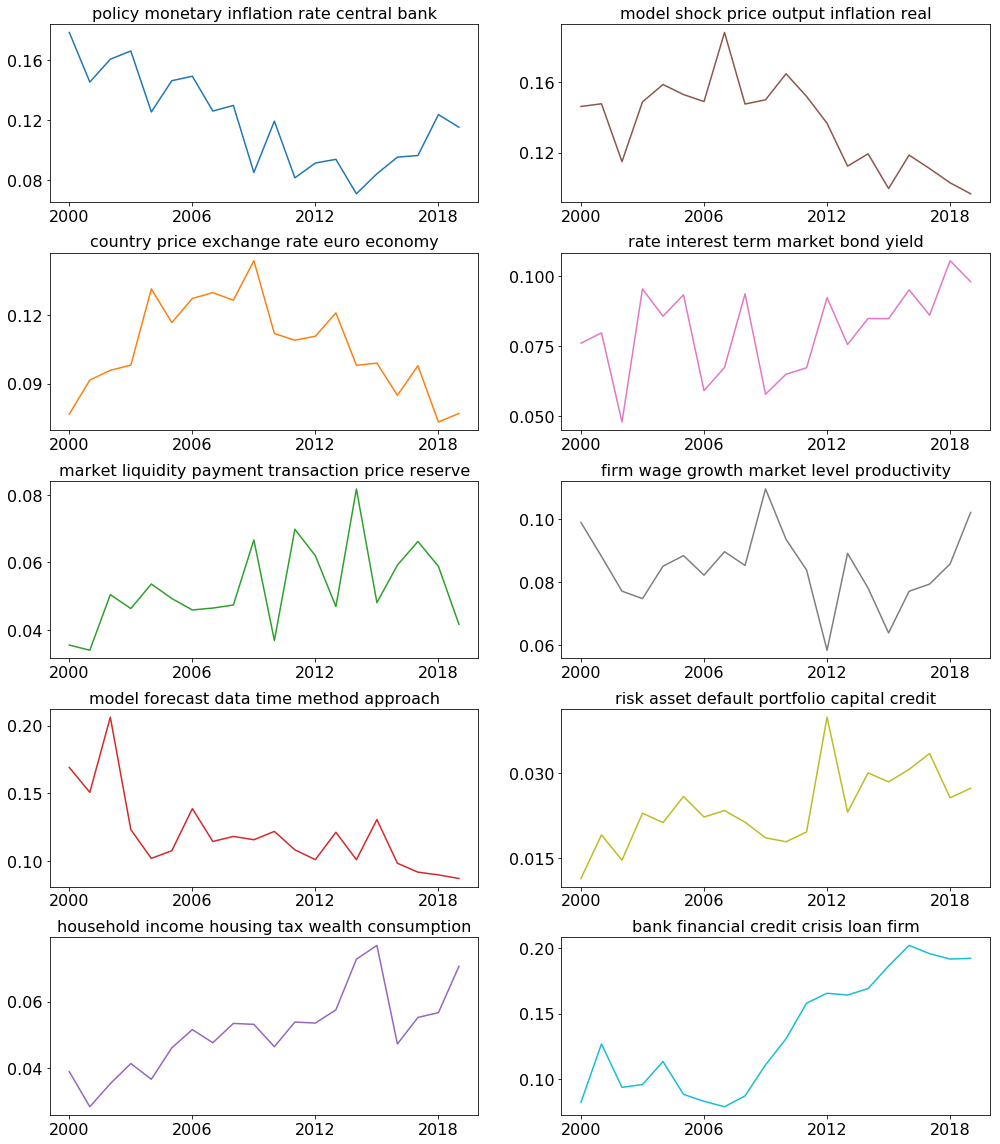

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,16))

ax11 = axes[0][0]
ax12 = axes[1][0]
ax13 = axes[2][0]
ax14 = axes[3][0]
ax15 = axes[4][0]

ax21 = axes[0][1]
ax22 = axes[1][1]
ax32 = axes[2][1]
ax42 = axes[3][1]
ax52 = axes[4][1]


for ax in [ax11, ax12, ax13, ax14, ax15, ax21, ax22, ax32, ax42, ax52]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

ax11.plot(years_strength.iloc[:,0],color='tab:blue')
ax11.set_title(topics_words_list[0],fontsize=16)

ax12.plot(years_strength.iloc[:,1],color='tab:orange')
ax12.set_title(topics_words_list[1],fontsize=16)

ax13.plot(years_strength.iloc[:,2],color='tab:green')
ax13.set_title(topics_words_list[2],fontsize=16)

ax14.plot(years_strength.iloc[:,3],color='tab:red')
ax14.set_title(topics_words_list[3],fontsize=16)

ax15.plot(years_strength.iloc[:,4],color='tab:purple')
ax15.set_title(topics_words_list[4],fontsize=16)

ax21.plot(years_strength.iloc[:,5],color='tab:brown')
ax21.set_title(topics_words_list[5],fontsize=16)

ax22.plot(years_strength.iloc[:,6],color='tab:pink')
ax22.set_title(topics_words_list[6],fontsize=16)

ax32.plot(years_strength.iloc[:,7],color='tab:grey')
ax32.set_title(topics_words_list[7],fontsize=16)

ax42.plot(years_strength.iloc[:,8],color='tab:olive')
ax42.set_title(topics_words_list[8],fontsize=16)

ax52.plot(years_strength.iloc[:,9],color='tab:cyan')
ax52.set_title(topics_words_list[9],fontsize=16)

plt.tight_layout()
plt.savefig('topic_trends')
plt.show()

#### Examine which topics have significant time trend (at the 0.01 per cent level)

In [36]:
#Print topics with significant time trends

from scipy import stats
import numpy as np

for topic in np.arange(0,9):
    p_value = stats.linregress(years_strength.iloc[:,topic],np.arange(0,len(years_strength)))[3]
    if p_value <= 0.01:
        print(topics_words_list[topic]+':','p-value:',
              stats.linregress(years_strength.iloc[:,topic],np.arange(0,len(years_strength)))[3])

policy monetary inflation rate central bank: p-value: 0.00015515167357535526
model forecast data time method approach: p-value: 0.0005101678689634517
household income housing tax wealth consumption: p-value: 3.155727622303953e-05
model shock price output inflation real: p-value: 0.00215840963299759
risk asset default portfolio capital credit: p-value: 0.0012848443071282933


## SIGNIFICANT TOPIC TRENDS

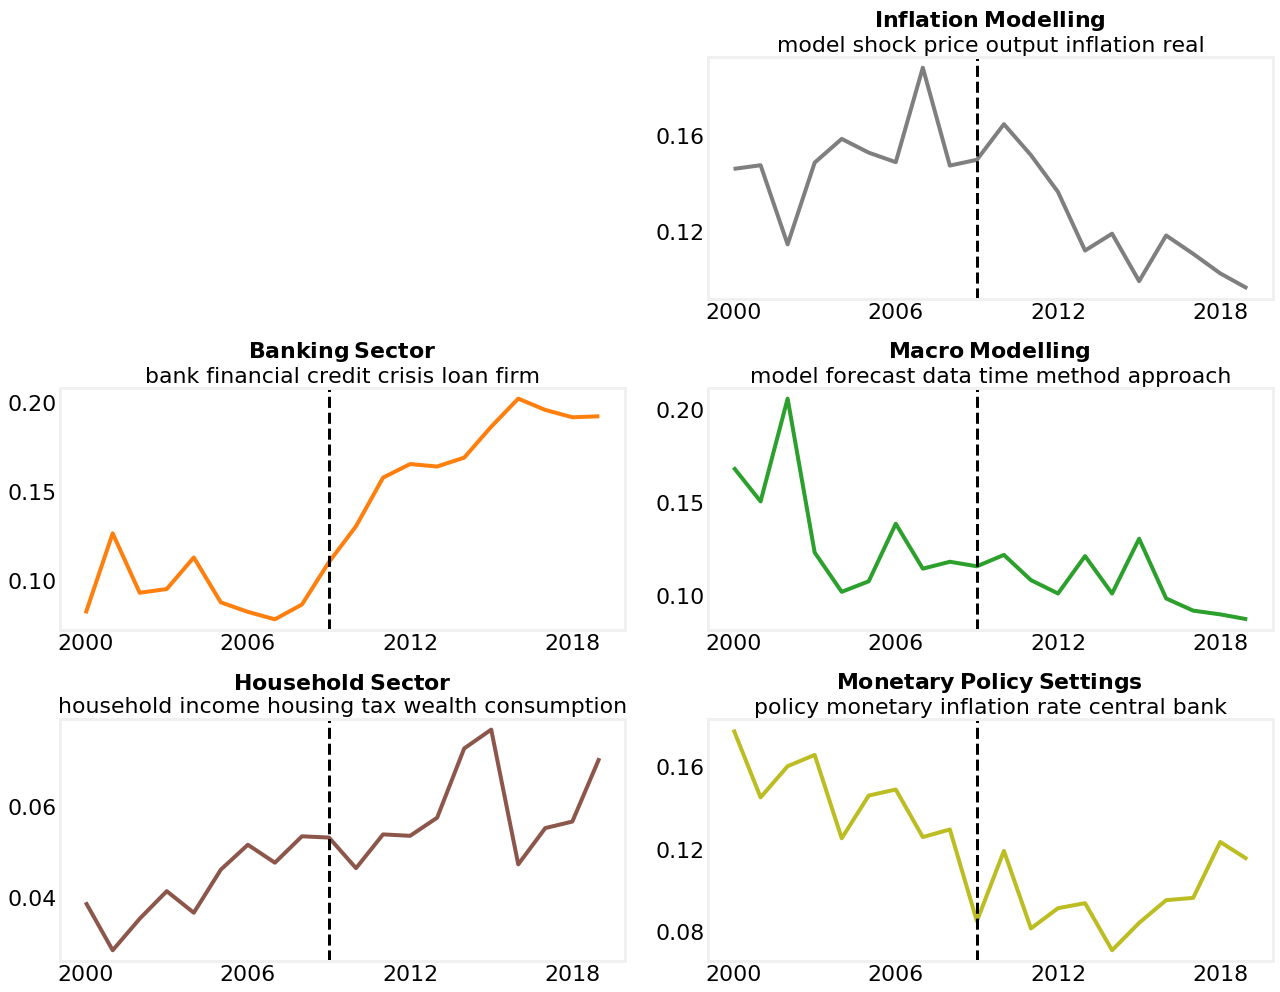

In [37]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18,14), facecolor='white')

ax1 = plt.subplot2grid(shape=(3,4), loc=(1,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (2,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax5 = plt.subplot2grid((3,4), (2,2), colspan=2)

# ax11 = axes[0]
# ax12 = axes[1]
# ax13 = axes[2]
# ax14 = axes[3]
# ax15 = axes[4]

for ax in [ax1, ax2, ax3, ax4, ax5]:
    # Clear x axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    ax.grid(False)
    ax.set_facecolor('white')

ax1.plot(years_strength.iloc[:,9],color='tab:orange')
ax1.set_title("$\mathbf{Banking\:Sector}$ \n"+topics_words_list[9],fontsize=22)

ax2.plot(years_strength.iloc[:,3],color='tab:green')
ax2.set_title("$\mathbf{Macro\:Modelling}$ \n"+topics_words_list[3],fontsize=22)

ax3.plot(years_strength.iloc[:,4],color='tab:brown')
ax3.set_title("$\mathbf{Household\:Sector}$ \n"+topics_words_list[4],fontsize=22)

ax4.plot(years_strength.iloc[:,5],color='tab:grey')
ax4.set_title("$\mathbf{Inflation\:Modelling}$ \n"+topics_words_list[5],fontsize=22)

ax5.plot(years_strength.iloc[:,0],color='tab:olive')
ax5.set_title("$\mathbf{Monetary\:Policy\:Settings}$ \n"+topics_words_list[0],fontsize=22)

x0 = int(ax1.get_xlim()[0]) # left boundary of x-axis (plot reference point)
gfc = x0+9

ax1.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax2.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax3.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax4.axvline(gfc,ls='--',c='k',lw=3,label='test start')
ax5.axvline(gfc,ls='--',c='k',lw=3,label='test start')

plt.tight_layout()
plt.savefig('sig_topic_trends.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

#### Word clouds

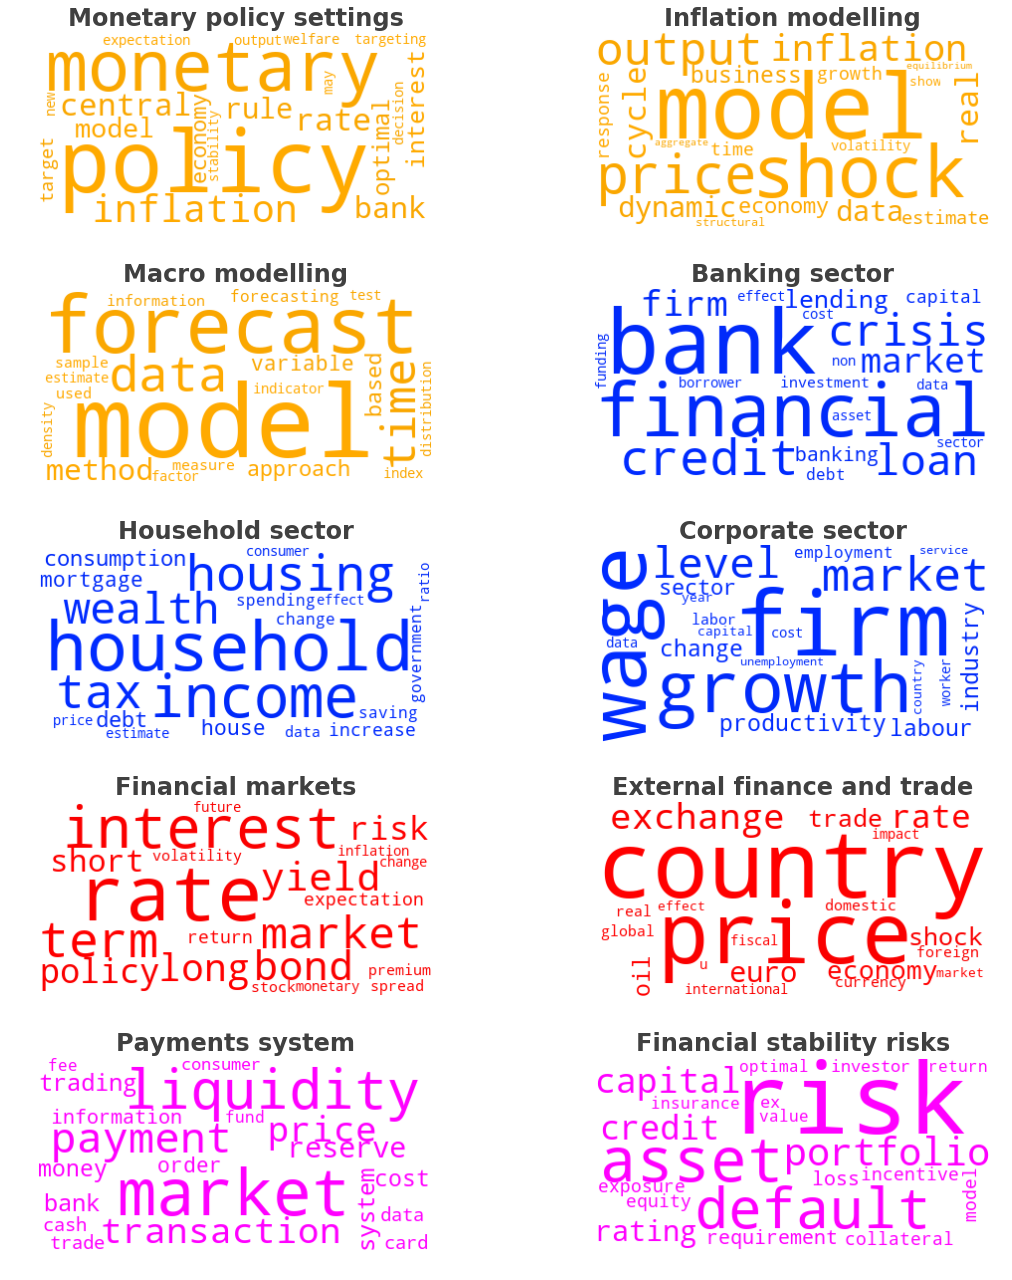

In [38]:
# def grey(word, font_size, position, orientation, random_state=None,
#                     **kwargs):
#     return "hsl(20, 100%%, %d%%)" % np.random.randint(60, 100)

def model(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(40,100%%, %d%%)" % np.random.randint(49,51))
def analysis(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))
def mkts(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(49,51))
def other(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(300,150%%, %d%%)" % np.random.randint(49,51))

topic_1 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(0, 20)))
topic_2 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(1, 20)))
topic_3 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(2, 20)))
topic_4 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(3, 20)))
topic_5 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(4, 20)))
topic_6 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(5, 20)))
topic_7 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(6, 20)))
topic_8 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(7, 20)))
topic_9 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(8, 20)))
topic_10 = WordCloud(background_color ='white').fit_words(dict(ldamodel.show_topic(9, 20)))

# Establish framework for subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,18), facecolor='white')

ax00 = axes[0][0]
ax10 = axes[1][0]
ax20 = axes[2][0]
ax30 = axes[3][0]
ax40 = axes[4][0]

ax01 = axes[0][1]
ax11 = axes[1][1]
ax21 = axes[2][1]
ax31 = axes[3][1]
ax41 = axes[4][1]

for ax in [ax00, ax10, ax20, ax30, ax40,
           ax01, ax11, ax21, ax31, ax41]:
    ax.set_facecolor('white')

# Subplot
ax00.set_title('Monetary policy settings', fontsize = 24, weight = 'bold', alpha = .75)
ax00.imshow(topic_1.recolor(color_func=model), interpolation="bilinear")
ax00.axis("off") 

# Subplot
ax01.set_title('Inflation modelling', fontsize = 24, weight = 'bold', alpha = .75)
ax01.imshow(topic_6.recolor(color_func=model), interpolation="bilinear")
ax01.axis("off") 

# Subplot
ax10.set_title('Macro modelling', fontsize = 24, weight = 'bold', alpha = .75)
ax10.imshow(topic_4.recolor(color_func=model), interpolation="bilinear")
ax10.axis("off") 

# Subplot
ax11.set_title('Banking sector', fontsize = 24, weight = 'bold', alpha = .75)
ax11.imshow(topic_10.recolor(color_func=analysis), interpolation="bilinear")
ax11.axis("off") 

# Subplot
ax20.set_title('Household sector', fontsize = 24, weight = 'bold', alpha = .75)
ax20.imshow(topic_5.recolor(color_func=analysis), interpolation="bilinear")
ax20.axis("off") 

# Subplot
ax21.set_title('Corporate sector', fontsize = 24, weight = 'bold', alpha = .75)
ax21.imshow(topic_8.recolor(color_func=analysis), interpolation="bilinear")
ax21.axis("off") 

# Subplot
ax30.set_title('Financial markets', fontsize = 24, weight = 'bold', alpha = .75)
ax30.imshow(topic_7.recolor(color_func=mkts), interpolation="bilinear")
ax30.axis("off") 

# Subplot
ax31.set_title('External finance and trade', fontsize = 24, weight = 'bold', alpha = .75)
ax31.imshow(topic_2.recolor(color_func=mkts), interpolation="bilinear")
ax31.axis("off") 

# Subplot
ax40.set_title('Payments system', fontsize = 24, weight = 'bold', alpha = .75)
ax40.imshow(topic_3.recolor(color_func=other), interpolation="bilinear")
ax40.axis("off") 

# Subplot
ax41.set_title('Financial stability risks', fontsize = 24, weight = 'bold', alpha = .75)
ax41.imshow(topic_9.recolor(color_func=other), interpolation="bilinear")
ax41.axis("off")

# Make subplots close to each other
fig.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig('wordclouds.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

#### Create a table with:
* topic words
* mean topic proportion in all abstracts
* number of times the topic has the highest weight in an abstract
* subjective topic label

In [39]:
topics_words_list

['policy monetary inflation rate central bank',
 'country price exchange rate euro economy',
 'market liquidity payment transaction price reserve',
 'model forecast data time method approach',
 'household income housing tax wealth consumption',
 'model shock price output inflation real',
 'rate interest term market bond yield',
 'firm wage growth market level productivity',
 'risk asset default portfolio capital credit',
 'bank financial credit crisis loan firm']

In [40]:
# # create dataframe with a column for hightest topic weight per abstract
# data_pre                      = data[data.Year < '2008']
# topic_max                     = data_pre.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
# topic_max['topic_max']        = topic_max.idxmax(axis=1)
# topic_max['topic_max_weight'] = topic_max.max(axis=1)

# # For each topic, count the number of abstracts that hasthat topic as the highest weight
# no_articles                   = topic_max['topic_max'].value_counts()
# no_articles                   = pd.DataFrame(no_articles)

# # Create dataframe with average topic weight across all abstracts 
# proportion                    = data_pre.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
# proportion                    = proportion.mean(axis=0)
# proportion                    = pd.DataFrame(proportion,columns=['topic_proportion'])

# # Combine dataframes
# combined_pre                  = no_articles.merge(proportion, how='outer', left_index=True, right_index=True)

# # Add topic labels
# topic_name = []
# topic_name = [
#     'Banking sector',
#     'International finance and trade',
#     'Corporate sector',
#     'Household sector',
#     'Payments system',
#     'Macro modelling',
#     'Inflation modelling',
#     'Monetary policy settings',    
#     'Financial markets',
#     'Financial stability risks']
# combined_pre['topic_label'] = topic_name
# combined_pre = combined_pre.sort_values(['topic_proportion'],ascending=False)

# # add topic rank
# combined_pre['topic_rank'] = [1,2,3,4,5,6,7,8,9,10]
# combined_pre

In [41]:
# # create dataframe with a column for hightest topic weight per abstract
# data_post                     = data[data.Year > '2007']
# topic_max                     = data_post.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
# topic_max['topic_max']        = topic_max.idxmax(axis=1)
# topic_max['topic_max_weight'] = topic_max.max(axis=1)

# # For each topic, count the number of abstracts that hasthat topic as the highest weight
# no_articles                   = topic_max['topic_max'].value_counts()
# no_articles                   = pd.DataFrame(no_articles)

# # Create dataframe with average topic weight across all abstracts 
# proportion                    = data_post.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
# proportion                    = proportion.mean(axis=0)
# proportion                    = pd.DataFrame(proportion,columns=['topic_proportion'])

# # Combine dataframes
# combined_post                 = no_articles.merge(proportion, how='outer', left_index=True, right_index=True)

# # Add ranking
# combined_post['topic_rank']   = [1,2,3,4,5,6,7,8,9,10]

# # Add topic labels
# topic_name = []
# topic_name = [
#     'Banking sector',
#     'International finance and trade',
#     'Corporate sector',
#     'Household sector',
#     'Financial markets',
#     'Macro modelling',
#     'Inflation modelling',
#     'Monetary policy settings',    
#     'Financial markets',
#     'Financial stability risks']
# combined_post['topic_label'] = topic_name
# combined_post = combined_post.sort_values(['topic_proportion'],ascending=False)

# # add topic rank
# combined_post['topic_rank'] = [1,2,3,4,5,6,7,8,9,10]
# combined_post

In [42]:
# create dataframe with a column for hightest topic weight per abstract
data_post                     = data
topic_max                     = data_post.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
topic_max['topic_max']        = topic_max.idxmax(axis=1)
topic_max['topic_max_weight'] = topic_max.max(axis=1)

# For each topic, count the number of abstracts that hasthat topic as the highest weight
no_articles                   = topic_max['topic_max'].value_counts()
no_articles                   = pd.DataFrame(no_articles)

# Create dataframe with average topic weight across all abstracts 
proportion                    = data_post.drop(['Author/s','Title','ID','Abstract','Central_Bank','topics','Year'],axis=1)
proportion                    = proportion.mean(axis=0)
proportion                    = pd.DataFrame(proportion,columns=['topic_proportion'])

# Combine dataframes
combined_post                 = no_articles.merge(proportion, how='outer', left_index=True, right_index=True)

# Add ranking
combined_post['topic_rank']   = [1,2,3,4,5,6,7,8,9,10]

# Add topic labels
topic_name = []
topic_name = [
    'Banking sector',
    'International finance and trade',
    'Corporate sector',
    'Household sector',
    'Payments system',
    'Macro modelling',
    'Inflation modelling',
    'Monetary policy settings',    
    'Financial markets',
    'Financial stability risks']
combined_post['topic_label'] = topic_name
combined_post = combined_post.sort_values(['topic_proportion'],ascending=False)

# add topic rank
combined_post['topic_rank'] = [1,2,3,4,5,6,7,8,9,10]
combined_post

,topic_max,topic_proportion,topic_rank,topic_label
bank financial credit crisis loan firm,1183,0.138572,1,Banking sector
model shock price output inflation real,895,0.135696,2,Inflation modelling
model forecast data time method approach,864,0.117307,3,Macro modelling
policy monetary inflation rate central bank,814,0.115756,4,Monetary policy settings
country price exchange rate euro economy,764,0.107397,5,International finance and trade
firm wage growth market level productivity,590,0.083502,6,Corporate sector
rate interest term market bond yield,577,0.081009,7,Financial markets
market liquidity payment transaction price reserve,412,0.053714,8,Payments system
household income housing tax wealth consumption,428,0.051880,9,Household sector
risk asset default portfolio capital credit,110,0.024477,10,Financial stability risks


In [43]:
# topic_rank_pre          = pd.DataFrame(combined_pre['topic_rank'])
# topic_rank_post         = pd.DataFrame(combined_post['topic_rank'])
# changes                 = topic_rank_pre.merge(topic_rank_post, how='outer', left_index=True, right_index=True)
# changes['changes']      = np.abs(changes["topic_rank_x"]-changes["topic_rank_y"])
# changes                 = changes.sort_values(['changes'],ascending=False)
# changes
# topic_name = ['Inflation modelling',
#     'Banking sector and financial stability',
#     'Household sector',
#     'Fixed income markets',
#     'International policy and trade',
#     'Corporate sector',
#     'Monetary policy transmission',
#     'Financial markets',
#     'Macro modelling',
#     'Price shocks and dynamics']
# changes['topic_label'] = topic_name

# changes = changes.reset_index()
# changes = changes.drop(['index'],axis=1)
# cols    = list(changes.columns)
# cols    = [cols[-1]] + cols[:-1]
# changes = changes[cols]
# changes

In [44]:
import seaborn as sns

# data preparation
dendro = data.drop(['Author/s','Title','ID','Abstract','topics','Year'],axis=1).groupby('Central_Bank').mean()
dendro_rank = dendro.rename(columns={"household income housing tax wealth consumption": "Household Sector",
                      "policy monetary inflation rate central bank": "Inflation Modelling",
                      "country price exchange rate euro economy": "External Sector",
                      "rate interest term market bond yield": "Financial Markets",
                      "market liquidity payment transaction price reserve":"Payments system",
                      "model forecast data time method approach":"Macro modelling",
                      "risk asset default portfolio capital credit":"Financial stability risks",
                      "firm wage growth market level productivity":"Corporate Sector",
                      "model shock price output inflation real":"Monetary Policy Transmission",
                      "bank financial credit crisis loan firm":"Banking Sector"})


# dendro_rank = dendro_rank.rank(axis=1,ascending=False).transpose().round(0)
# dendro_rank.astype(int)
dendro_rank

,Inflation Modelling,External Sector,Payments system,Macro modelling,Household Sector,Monetary Policy Transmission,Financial Markets,Corporate Sector,Financial stability risks,Banking Sector
Central_Bank,,,,,,,,,,
BoC,0.099851,0.092145,0.074954,0.157382,0.038940,0.152021,0.061206,0.068408,0.030775,0.125120
BoE,0.102951,0.076476,0.049820,0.092194,0.037657,0.161228,0.087794,0.066666,0.031665,0.197544
BoJ,0.102901,0.098865,0.046411,0.106800,0.025444,0.138458,0.137203,0.100313,0.017311,0.125591
ECB,0.124690,0.172402,0.040074,0.112360,0.034802,0.128142,0.065969,0.082648,0.017155,0.130352
Norges,0.161854,0.113431,0.070678,0.165224,0.035722,0.141893,0.053959,0.047574,0.030324,0.104748
RBA,0.100205,0.138468,0.078870,0.088902,0.084995,0.134987,0.075375,0.099268,0.013114,0.102757
RBNZ,0.199261,0.147113,0.013790,0.141230,0.043917,0.165676,0.094215,0.066518,0.005424,0.041610
Riksbank,0.179381,0.072616,0.042671,0.158823,0.039401,0.173889,0.054470,0.056411,0.023929,0.124629
US,0.090402,0.028635,0.064503,0.097464,0.099275,0.113589,0.111986,0.111040,0.032654,0.161472


/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


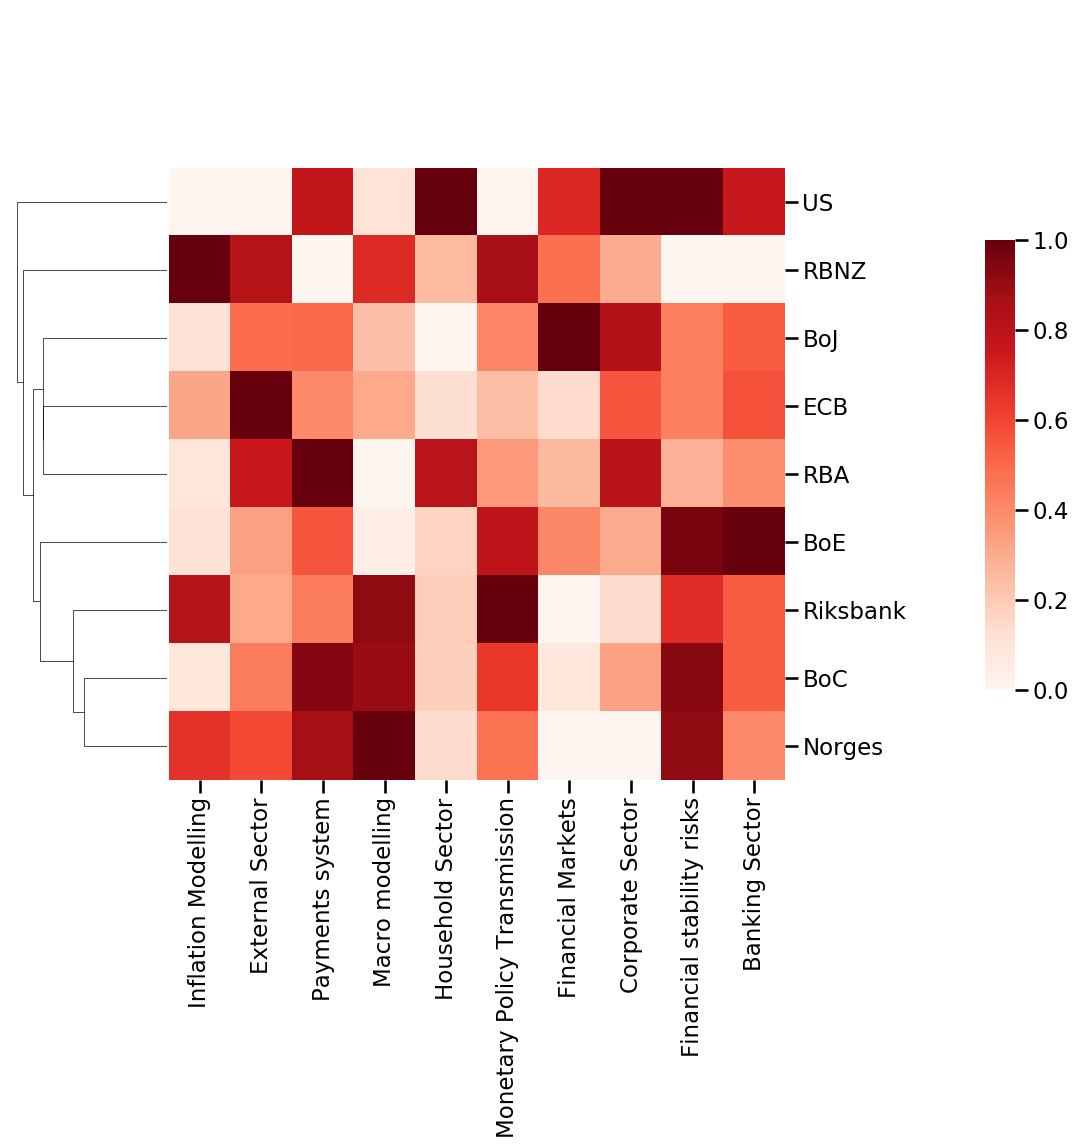

In [45]:
# dendro = dendro.rename(columns={"household income housing tax wealth consumption": "Household Sector",
#                       "policy monetary inflation rate central bank": "Inflation Modelling",
#                       "country price exchange rate euro economy": "External Sector",
#                       "rate interest term market bond yield": "Financial Markets",
#                       "market liquidity payment transaction price reserve":"Payments system",
#                       "model forecast data time method approach":"Macro modelling",
#                       "risk asset default portfolio capital credit":"Financial stability risks",
#                       "firm wage growth market level productivity":"Corporate Sector",
#                       "model shock price output inflation real":"Monetary Policy Transmission",
#                       "bank financial credit crisis loan firm":"Banking Sector"})
# plot
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context("talk")
g  = sns.clustermap(dendro_rank, method="single",cmap="Reds", standard_scale=1,col_cluster=False)
ax = g.ax_heatmap
g.cax.set_position([1.1, .2, .03, .45])
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig('dendro.png',bbox_inches='tight')
plt.show()

In [46]:
dendro = dendro.rename(columns={"household income housing tax wealth consumption": "Household Sector",
                      "policy monetary inflation rate central bank": "Inflation Modelling",
                      "country price exchange rate euro economy": "External Sector",
                      "rate interest term market bond yield": "Financial Markets",
                      "market liquidity payment transaction price reserve":"Payments system",
                      "model forecast data time method approach":"Macro modelling",
                      "risk asset default portfolio capital credit":"Financial stability risks",
                      "firm wage growth market level productivity":"Corporate Sector",
                      "model shock price output inflation real":"Monetary Policy Transmission",
                      "bank financial credit crisis loan firm":"Banking Sector"})
dendro

,Inflation Modelling,External Sector,Payments system,Macro modelling,Household Sector,Monetary Policy Transmission,Financial Markets,Corporate Sector,Financial stability risks,Banking Sector
Central_Bank,,,,,,,,,,
BoC,0.099851,0.092145,0.074954,0.157382,0.038940,0.152021,0.061206,0.068408,0.030775,0.125120
BoE,0.102951,0.076476,0.049820,0.092194,0.037657,0.161228,0.087794,0.066666,0.031665,0.197544
BoJ,0.102901,0.098865,0.046411,0.106800,0.025444,0.138458,0.137203,0.100313,0.017311,0.125591
ECB,0.124690,0.172402,0.040074,0.112360,0.034802,0.128142,0.065969,0.082648,0.017155,0.130352
Norges,0.161854,0.113431,0.070678,0.165224,0.035722,0.141893,0.053959,0.047574,0.030324,0.104748
RBA,0.100205,0.138468,0.078870,0.088902,0.084995,0.134987,0.075375,0.099268,0.013114,0.102757
RBNZ,0.199261,0.147113,0.013790,0.141230,0.043917,0.165676,0.094215,0.066518,0.005424,0.041610
Riksbank,0.179381,0.072616,0.042671,0.158823,0.039401,0.173889,0.054470,0.056411,0.023929,0.124629
US,0.090402,0.028635,0.064503,0.097464,0.099275,0.113589,0.111986,0.111040,0.032654,0.161472


In [47]:
from collections import Counter
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in abst for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])  
# Set Age_Group value for all row indexes which Age are greater than 40
df['Topic_name'] = ''
df['Topic_name'][df['topic_id'] == 0] = 'Policy settings'
df['Topic_name'][df['topic_id'] == 1] = 'External sector'
df['Topic_name'][df['topic_id'] == 2] = 'Payments system'
df['Topic_name'][df['topic_id'] == 3] = 'Macro modelling'
df['Topic_name'][df['topic_id'] == 4] = 'Household sector'
df['Topic_name'][df['topic_id'] == 5] = 'Inflation modelling'
df['Topic_name'][df['topic_id'] == 6] = 'Financial markets'
df['Topic_name'][df['topic_id'] == 7] = 'Corporate sector'
df['Topic_name'][df['topic_id'] == 8] = 'Financial stability risks'
df['Topic_name'][df['topic_id'] == 9] = 'Banking sector'

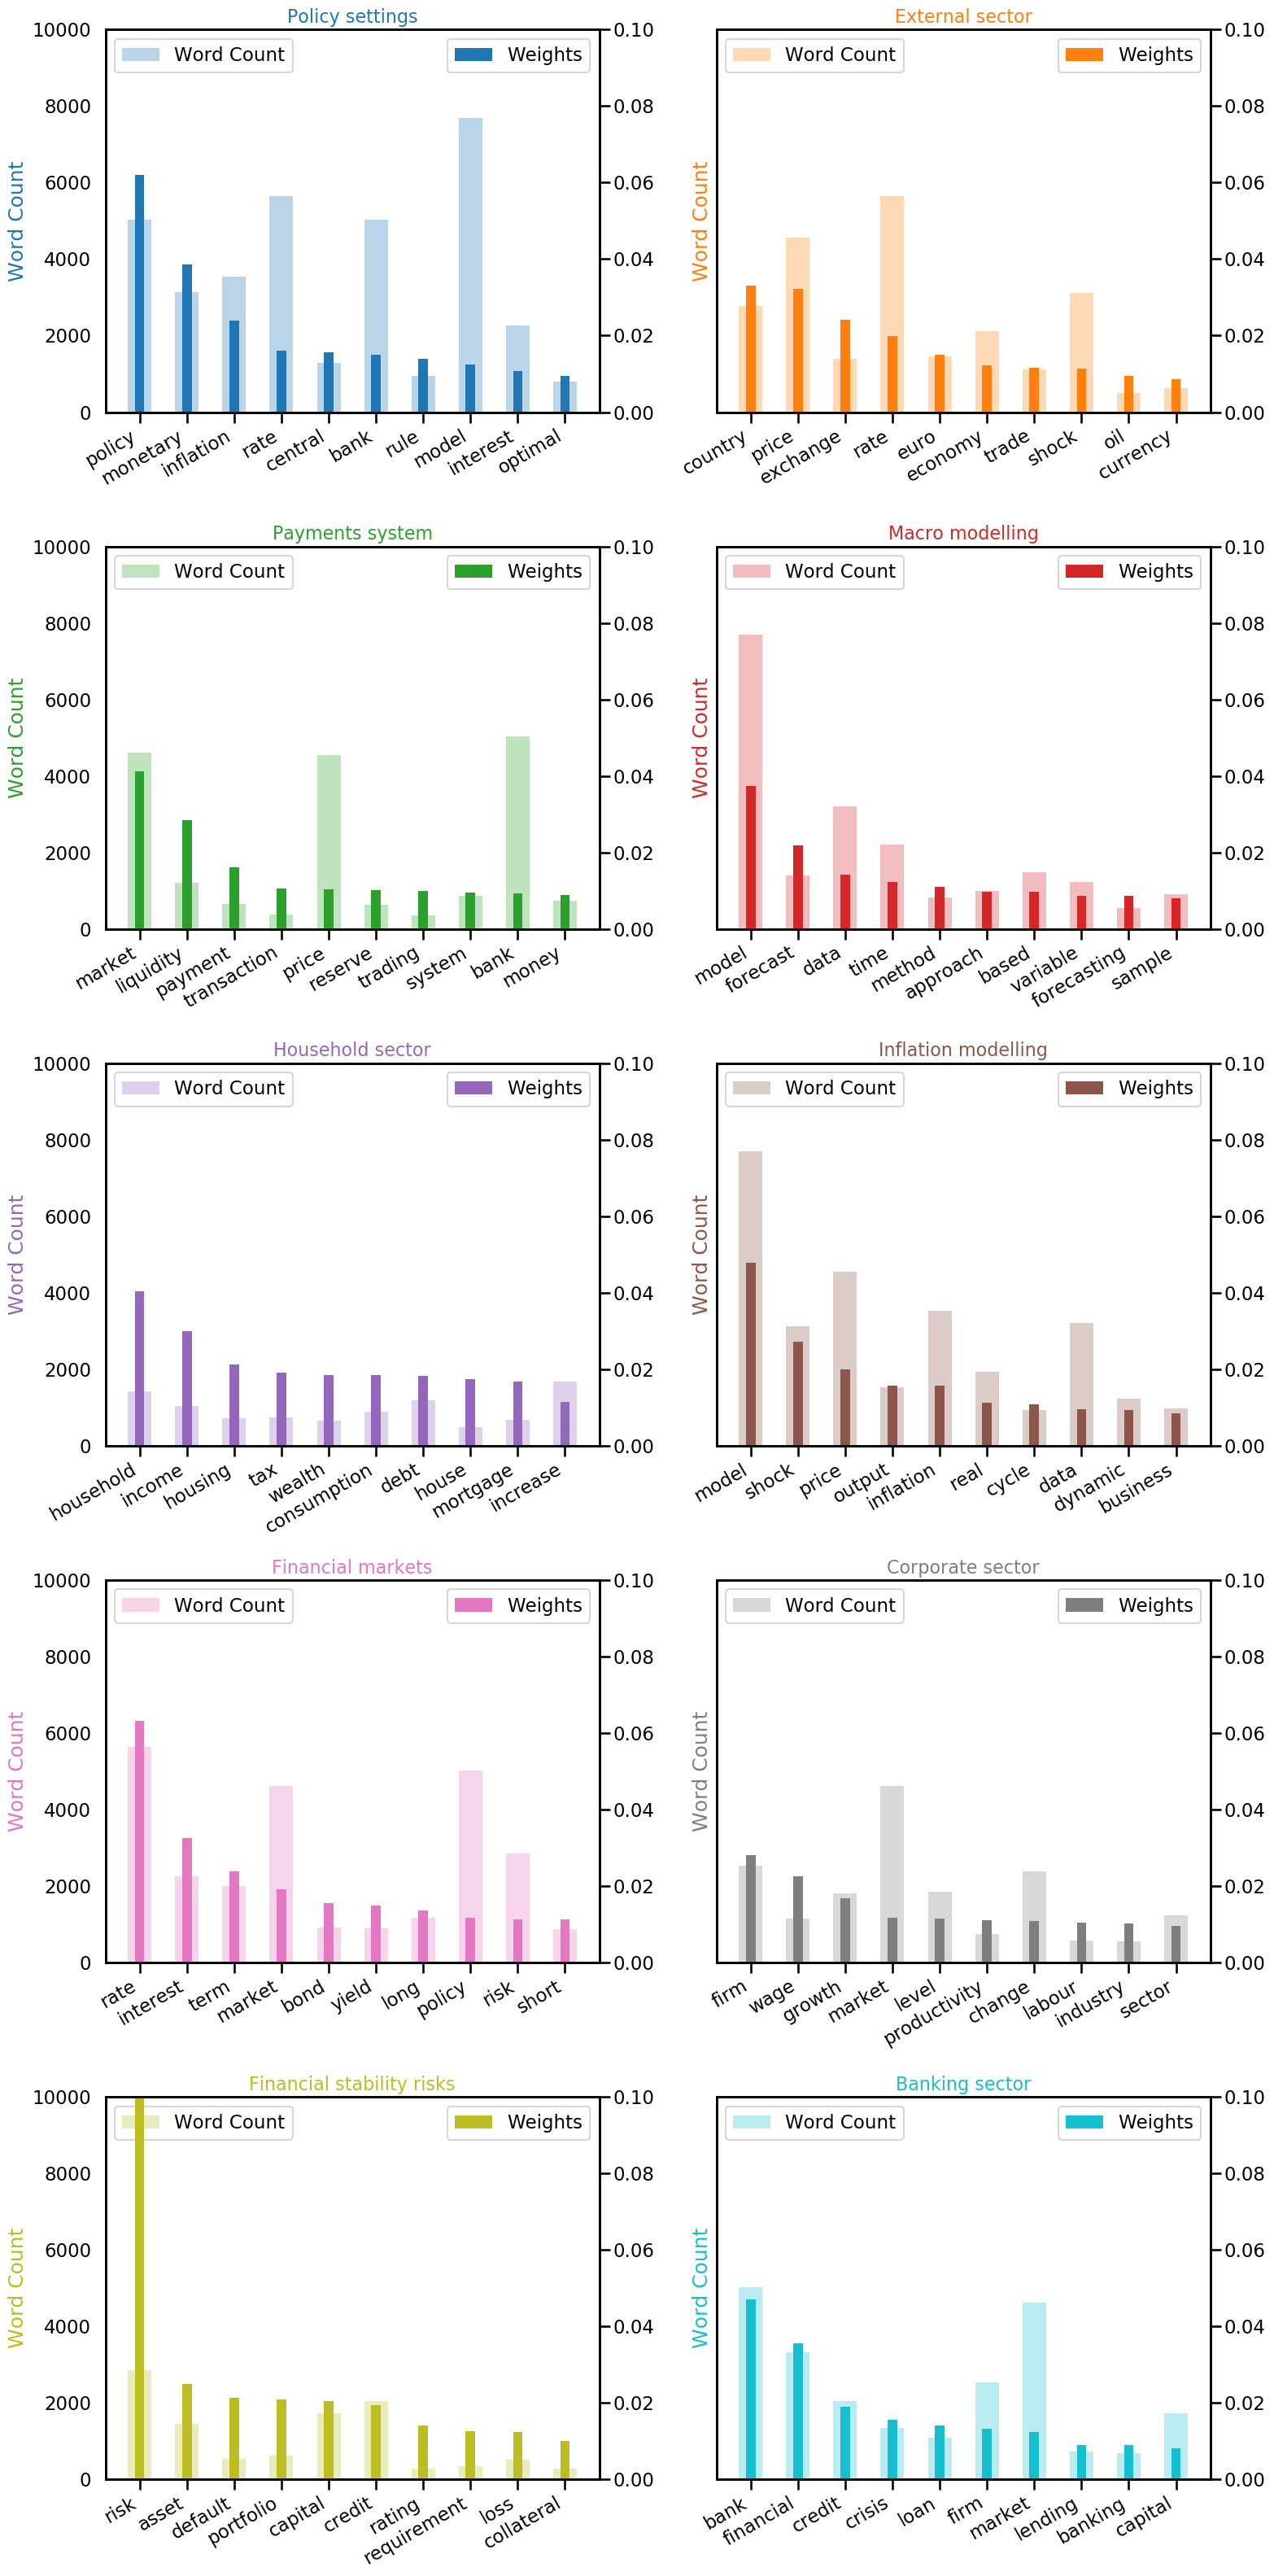

In [48]:
import matplotlib.colors as mcolors
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,32), sharey=True, facecolor='white')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.1); ax.set_ylim(0, 10000)
    ax.set_title(df.Topic_name.loc[df.topic_id==i][i*10], color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    ax.grid(False)
    ax.set_facecolor('white')

fig.tight_layout()    
#fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.01)    
plt.savefig('word_dist.pdf',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [49]:
hm = np.array([[y for (x,y) in ldamodel.get_document_topics(corpus[i],minimum_probability=0)] for i in range(len(corpus))])

#### Examine how the topics cluster

In [52]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for row_list in ldamodel[corpus]:
    tmp = np.zeros(10)
    for i, w in row_list:
        tmp[i] = w
    topic_weights.append(tmp)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6637 samples in 0.021s...
[t-SNE] Computed neighbors for 6637 samples in 0.666s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6637
[t-SNE] Computed conditional probabilities for sample 2000 / 6637
[t-SNE] Computed conditional probabilities for sample 3000 / 6637
[t-SNE] Computed conditional probabilities for sample 4000 / 6637
[t-SNE] Computed conditional probabilities for sample 5000 / 6637
[t-SNE] Computed conditional probabilities for sample 6000 / 6637
[t-SNE] Computed conditional probabilities for sample 6637 / 6637
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.968063
[t-SNE] Error after 1000 iterations: 1.494937


Loading BokehJS ...

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=2017, perplexity=30)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

In [ ]:
embedding.head()

* 'policy monetary inflation rate central bank',
* 'country price exchange rate euro economy',
* 'market liquidity payment transaction price reserve',
* 'model forecast data time method approach',
* 'household income housing tax wealth consumption',
* 'model shock price output inflation real',
* 'rate interest term market bond yield',
* 'firm wage growth market level productivity',
* 'risk asset default portfolio capital credit',
* 'bank financial credit crisis loan firm'